In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np

import spacy
import nltk
import nltk.data
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import regex as re
import string
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.layers import Conv1D, Flatten, Bidirectional, LSTM, Dense, Input, Dropout, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import itertools

In [5]:
df = pd.read_csv('../data/input_tweets.csv')
print(df.head())

   Unnamed: 0         username  \
0           0  cristia89872894   
1           2      sccristiano   
2          12      Atorrante15   
3          16          _fedenb   
4          20  javier_eduardo3   

                                                                                                                                         acctdesc  \
0  Hincha del Apruebo, pero nunca de los Apruebistas...mi izquierda llega sólo hasta Mujica. Me gustan los chistes sobre estupideces posmodernas.   
1                                                                                                                                             NaN   
2                                                                                                                                             NaN   
3                                                                                                                           🍃ρєя αsρєяα α∂ αsтяα💫   
4                                                 

In [6]:
df.drop(columns = ['Unnamed: 0', 'acctdesc' ,'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'hashtags', ], inplace = True)
print(df.head(5))

          username  \
0  cristia89872894   
1      sccristiano   
2      Atorrante15   
3          _fedenb   
4  javier_eduardo3   

                                                                                                                                                                                                                                                                            text  \
0                                                              @liznorthon @SoyAIvaro @ursulaeggers @MielyMerken @AlessandriFelip Pillaron al presunto, es de nacionalidad colombiana. No es sorpresa, la violencia es parte del inmigrante de origen colombiano, es su cultura.   
1                                                                                                                                   @ccarvajaly Cuando se den cuenta que eran homicidas o narco y los pillen dirán hemos dado con este inmigrante ilegal que era un delincuente.   
2                                      

In [7]:
punctuations = "¡!#$%&'()*+,-./:;<=>¿?@[\]^_`{|}~"

def read_txt(filename):
    list = []
    with open(filename, 'r', encoding='utf-8') as f:
        data = f.readlines()
        for line in data:
            list.append(str(line).replace('\n', ''))
    return list

stopwords = read_txt('../data/spanish_stopwords.txt')

stemmer = SnowballStemmer('spanish')

In [8]:
def clean_accents(tweet):
    tweet = re.sub(r"[àáâãäå]", "a", tweet)
    tweet = re.sub(r"ç", "c", tweet)
    tweet = re.sub(r"[èéêë]", "e", tweet)
    tweet = re.sub(r"[ìíîï]", "i", tweet)
    tweet = re.sub(r"[òóôõö]", "o", tweet)
    tweet = re.sub(r"[ùúûü]", "u", tweet)
    tweet = re.sub(r"[ýÿ]", "y", tweet)

    return tweet

def clean_tweet(tweet, stem = False):
    tweet = tweet.lower().strip()
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    tweet = re.sub(r'http?:\/\/\S+', '', tweet)
    tweet = re.sub(r'www?:\/\/\S+', '', tweet)
    tweet = re.sub(r'\s([@#][\w_-]+)', "", tweet)
    tweet = re.sub(r"\n", " ", tweet)
    tweet = clean_accents(tweet)
    tweet = re.sub(r"\b(a*ha+h[ha]*|o?l+o+l+[ol]*|x+d+[x*d*]*|a*ja+[j+a+]+)\b", "<risas>", tweet)
    for symbol in punctuations:
        tweet = tweet.replace(symbol, "")
    tokens = []
    for token in tweet.strip().split():
        if token not in punctuations and token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [9]:
df['text_cleaned'] = df['text'].apply(lambda s : clean_tweet(s))
print(df['text_cleaned'].head(5))

0                                     liznorthon pillaron presunto nacionalidad colombiana no sorpresa violencia parte inmigrante origen colombiano cultura
1                                                         ccarvajaly den cuenta homicidas o narco pillen diran hemos dado inmigrante ilegal era delincuente
2           sergiochouza risas ahi estuviste bien chouza nota cabeza sudaca mal pagadorlo llevan adn esos papelitos paises serios compromiso vos sudacas no
3                                                                           aca ver aleman cabello rubio ojos celestes bardeando negro mierda mejor momento
4    senadochile murieron 8 compatriotas culpa inmigrante debio pisar chile ustedes dan lujo no sesionar inaccion complices esas muertes mano dura ilegales
Name: text_cleaned, dtype: object


In [10]:
df.drop_duplicates(subset=['text_cleaned'], keep='last', inplace = True)

In [11]:
vectorizer = TfidfVectorizer(min_df= 3, sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['text_cleaned']).toarray()
print(df['text_cleaned'])

0                                                                                 liznorthon pillaron presunto nacionalidad colombiana no sorpresa violencia parte inmigrante origen colombiano cultura
1                                                                                                     ccarvajaly den cuenta homicidas o narco pillen diran hemos dado inmigrante ilegal era delincuente
2                                                       sergiochouza risas ahi estuviste bien chouza nota cabeza sudaca mal pagadorlo llevan adn esos papelitos paises serios compromiso vos sudacas no
3                                                                                                                       aca ver aleman cabello rubio ojos celestes bardeando negro mierda mejor momento
4                                                senadochile murieron 8 compatriotas culpa inmigrante debio pisar chile ustedes dan lujo no sesionar inaccion complices esas muertes mano dura ilegales


In [18]:
X = df['text_cleaned']
Y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)

In [19]:
ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       299
           1       0.81      0.70      0.75       277

    accuracy                           0.78       576
   macro avg       0.78      0.77      0.77       576
weighted avg       0.78      0.78      0.77       576

[[253  46]
 [ 83 194]]


In [20]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

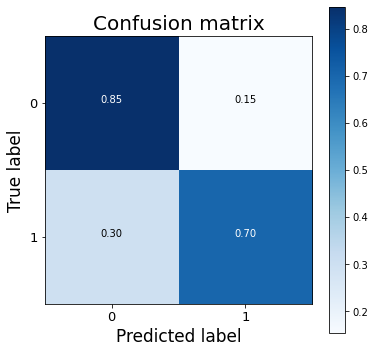

In [21]:
cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix")
plt.show()